In [1]:
!/opt/bin/nvidia-smi

/bin/bash: /opt/bin/nvidia-smi: No such file or directory


In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/MyDrive/project')
print(os.getcwd())

In [34]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import re
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error
from datetime import datetime
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
from keras.layers import Dense, Dropout, LSTM,Reshape, GRU,Conv1D, Conv2D,Flatten,Permute, multiply,BatchNormalization, Activation, AveragePooling1D, GlobalAveragePooling1D, Lambda, Input, Concatenate, Add, UpSampling1D, Multiply, ReLU
from keras.models import Model
from keras.utils.vis_utils import plot_model
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau,LearningRateScheduler
from keras.initializers import random_normal
from keras.optimizers import rmsprop_v2, adam_v2
from keras import regularizers
from keras.callbacks import Callback

In [35]:
import matplotlib.pyplot as plt

def plot_func(y_list, x_list, label_list, title):
  plt.figure()
  for i in range(len(x_list)):
    x = x_list[i]
    y = y_list[i]
    label = label_list[i]
    plt.plot(x, y, label=label)
  plt.title(title)
  plt.legend()
  plt.savefig('pics/'+title+'.png')
  plt.show()
  return


# ['loss', 'mse', 'val_loss', 'val_mse', 'lr']

def plot_all(hist, name):
  info_hist = hist.history
  y = np.array(hist.epoch) + 1
  plot_func([info_hist['loss']], [y], ['Train loss'], f'Train Loss Curve of {name}')
  plot_func([info_hist['val_loss']], [y], ['Val loss'], f'Val Loss Curve of {name}')
  plot_func([info_hist['loss'], info_hist['val_loss']], [y, y], ['Train loss', 'Val loss'], f'Loss Curve of {name}')
  plot_func([info_hist['mse']], [y], ['Train mse'], f'Train MSE Curve of {name}')
  plot_func([info_hist['val_mse']], [y], ['Val mse'], f'Val MSE Curve of {name}')
  plot_func([info_hist['mse'], info_hist['val_mse']], [y, y], ['Train mse', 'Val mse'], f'MSE Curve of {name}')
  plot_func([info_hist['lr']], [y], ['Learning rate'], f'Learning Rate Curve of {name}')

In [36]:
def plot_result(y_true,y_pre,model_name='LSTM'):
    x = range(len(y_true))
    
    plt.figure(dpi=200)
    plt.title(f'{model_name} Result Plot',fontsize=20)
    plt.xlabel(u'timestep',fontsize=14)
    plt.ylabel(u'y',fontsize=14)

    
    plt.plot(x,y_true,color="g",linewidth=1,label='label')
    plt.plot(x,y_pre,color="r",linewidth=1,label='predict')

    plt.legend(loc=2)
    plt.show()

In [37]:
config={
    'csv_path' : './FullRawChillerPlant.csv',# file to run
    'col' : 'CP_Chiller1_ChilledWaterReturnTemp', #column to predict
    'train_rate' : 0.7,
    'valid_rate' : 0.2,
    'seq_len' : 16,
    'epoch' : 50,
    'batch' : 128,
    'lr' : 0.0001,
}


In [38]:
def gen_data(df,config):
    col = config['col']
    window = config['seq_len']
    
    data = df[col].dropna().values
    print(data.shape)
    
    data = (data-np.min(data)) / (np.max(data)-np.min(data))
    
    X = np.zeros((len(data)-window,window,1))
    y = np.zeros((len(data)-window,window,1))
    
    for i in range(len(data)-window-1):
        X[i,:,0] = data[i:i+window]
        y[i,:,0] = data[i+1:i+window+1]
        
    return X,y



In [39]:
sample_df = pd.read_csv(config['csv_path'])
X,y = gen_data(sample_df,config)

(443254,)


In [40]:
del sample_df['Unnamed: 0'],sample_df['Unnamed: 0.1']
# sample_df.info(null_counts=True)/len(sample_df)

In [42]:
def nan_plot(df):
    plt.figure(dpi=200)
    x = list(df.columns)
    y = []
    for col in x:
        y.append((len(df) - df[col].count())/len(df))
    y_pos = [i for i in range(1,len(x)+1)]

    plt.bar(y_pos, y, align='center', alpha=0.7)
    plt.xticks(y_pos, x,rotation=90,fontsize=6)
    plt.xlabel('Columns')
    plt.ylabel('NAN Rate')
    plt.title('UWC Dataset')
#     plt.show()
    plt.savefig('./nanrate.jpg',bbox_inches='tight')



In [12]:
sample_df.describe()

,CP_Chiller1_ChilledWaterFlowrate,CP_Chiller1_ChilledWaterReturnTemp,CP_Chiller1_ChilledWaterSupplyTemp,CP_Chiller1_CondenserWaterFlowrate,CP_Chiller1_CondenserWaterReturnTemp,CP_Chiller1_CondenserWaterSupplyTemp,CP_Chiller1_CoolingTons,CP_Chiller1_Efficiency,CP_Chiller1_kW,CP_Chiller2_ChilledWaterFlowrate,...,CP_Chiller3_kW,CP_CoolingTower1_CondenserWaterSupplyTemp,CP_CoolingTower2_CondenserWaterSupplyTemp,CP_CoolingTower3_CondenserWaterSupplyTemp,CP_CoolingTower4_CondenserWaterSupplyTemp,CP_CoolingTower5_CondenserWaterSupplyTemp,CP_CoolingTower6_CondenserWaterSupplyTemp,CP_CoolingTower7_CondenserWaterSupplyTemp,CP_CoolingTower8_CondenserWaterSupplyTemp,CP_CoolingTower9_CondenserWaterSupplyTemp
count,443255.000000,443254.000000,443251.000000,443254.000000,443253.000000,443253.000000,443255.000000,443127.000000,443252.000000,443252.000000,...,443253.000000,443252.000000,443254.000000,443128.000000,443255.000000,443254.000000,443252.000000,443253.000000,443255.000000,443124.000000
mean,237.437821,12.379655,12.634202,384.876336,27.957502,26.372314,130.225982,0.123044,64.675955,250.449957,...,54.437454,27.559921,27.565455,27.577532,27.615182,27.649294,27.592209,27.596941,27.633713,27.594341
std,417.603199,3.032389,3.920817,683.084003,5.236639,4.295873,238.070593,0.229424,117.128422,420.981204,...,81.130565,4.508529,4.507503,4.514696,4.524359,4.531659,4.518824,4.518887,4.522731,4.520764
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,10.816000,8.970000,0.000000,26.410000,25.955999,0.000000,0.000000,0.000000,0.000000,...,0.000000,27.356001,27.361000,27.372999,27.399000,27.427000,27.389999,27.382000,27.427000,27.384001
50%,0.000000,11.994000,14.398000,0.000000,27.308001,26.774000,0.000000,0.000000,0.000000,0.000000,...,0.000000,28.281000,28.296000,28.304001,28.341000,28.367001,28.320999,28.327999,28.368999,28.336000
75%,563.222015,14.395000,15.594000,0.000000,29.219999,27.856001,0.000000,0.000000,0.000000,679.447735,...,134.200000,29.000000,29.011999,29.021999,29.062000,29.097000,29.037001,29.047001,29.084000,29.052999
max,1540.369000,24.448999,24.167999,1892.384000,46.445000,41.793999,949.960020,2.000000,338.160000,1521.761000,...,234.690000,58.373001,47.528000,57.367001,57.439999,57.393002,57.372002,46.453999,56.645000,56.674000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


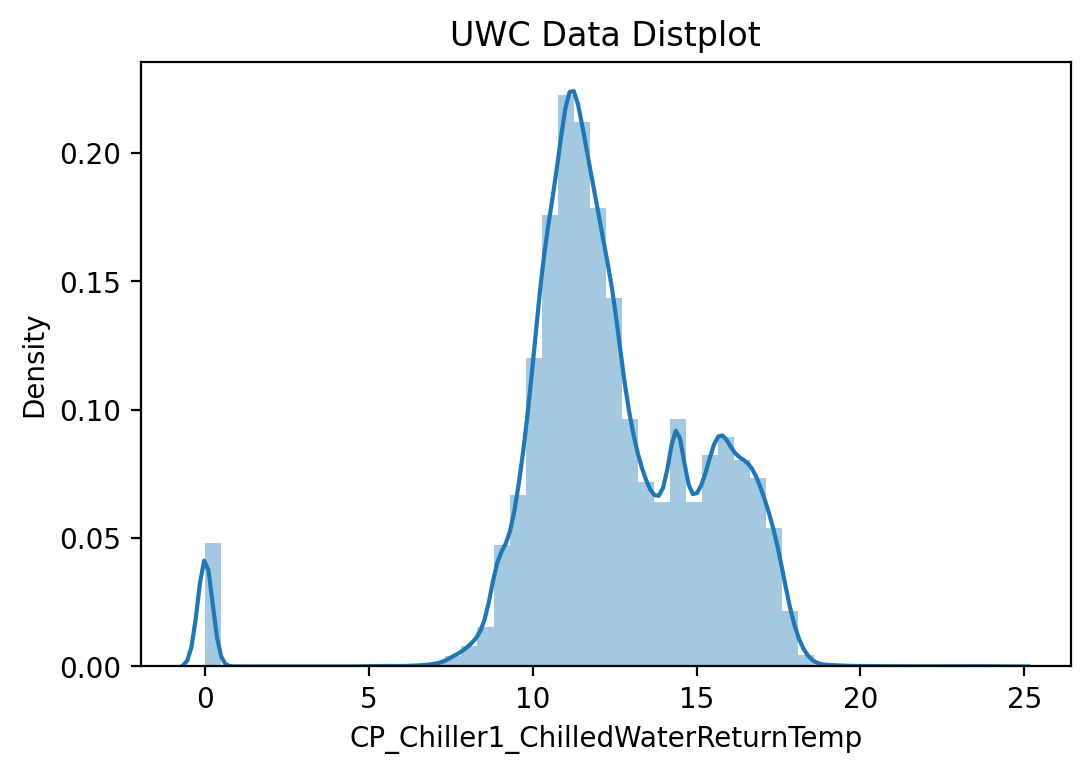

In [13]:
plt.figure(dpi=200)
sns.distplot(sample_df[config['col']])
plt.title('UWC Data Distplot')
plt.savefig('./uwc_dist.jpg')

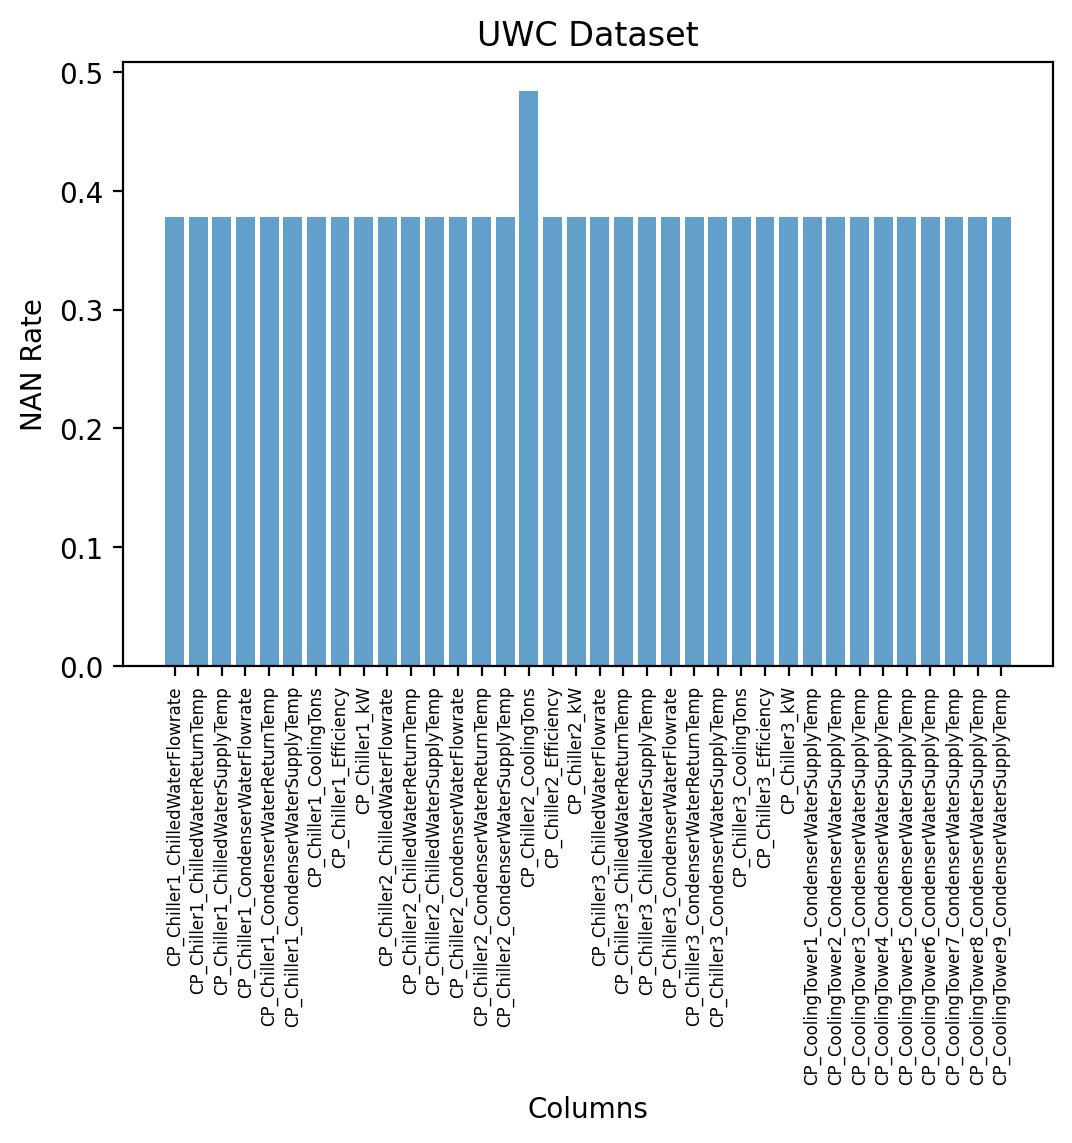

In [14]:
nan_plot(sample_df)

In [43]:
train_num = int(len(X)*config['train_rate'])
valid_num = int(len(X)*config['valid_rate'])
X_train = X[:train_num]
y_train = y[:train_num]
X_valid = X[train_num:train_num+valid_num]
y_valid = y[train_num:train_num+valid_num]
X_test = X[train_num+valid_num:]
y_test = y[train_num+valid_num:]


In [44]:
def lstm_model(seq_len):
    
    seq_input =  Input((seq_len,1), name='seq_input')

    x = LSTM(units=16,return_sequences=True)(seq_input)
    x = LSTM(units=16,return_sequences=False)(x)

    x = Dense(32,activation='tanh')(x)
    x = BatchNormalization()(x)
    
    out = Dense(1)(x)
    
    model = Model(inputs=seq_input, outputs=out)
    
    return model



In [45]:
def Residual_block(x,filters,kernel_size,n):
    dilation_rates = [2**i for i in range(n)]
    res_x = x
    skip_x = []
    for dilation_rate in dilation_rates:
        x = BatchNormalization()(x)
        x = Conv1D(filters=filters,
            kernel_size=kernel_size, 
            padding='causal',
            activation='tanh',
            dilation_rate=dilation_rate)(x)
        x = Conv1D(filters=1,
            kernel_size=1,
            padding='same'
            )(x)
        skip_x.append(x)
        res_x = Add()([res_x,x])
    ter_x = skip_x[0]
    for i in range(1, len(skip_x)):
        ter_x = Add()([ter_x, skip_x[i]])
    return ter_x


In [46]:
def SeriesNet(seq_len): 
    seq_input =  Input((seq_len,1), name='seq_input')
    #Lstm part
    x = LSTM(units=16,return_sequences=True)(seq_input)
    x = LSTM(units=16,return_sequences=True)(x)
    x = Dense(1,activation='tanh')(x)
    # x = BatchNormalization()(x)
    #Residual part
    x1 = Conv1D(filters=4,
          kernel_size=6, 
          padding='causal')(seq_input)
    x1 = Residual_block(x1,4,3,3)
    x1 = Residual_block(x1,8,3,2)
    x1 = Conv1D(filters=1,
          kernel_size=1, 
          padding='same')(x1)
    x = Multiply()([x,x1])
    out = ReLU()(x)
    model = Model(inputs=seq_input, outputs=out)
    return model


In [47]:
model1 = lstm_model(seq_len=config['seq_len'])
model2 = SeriesNet(seq_len=config['seq_len'])

In [20]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 seq_input (InputLayer)      [(None, 16, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 16, 16)            1152      
                                                                 
 lstm_1 (LSTM)               (None, 16)                2112      
                                                                 
 dense (Dense)               (None, 32)                544       
                                                                 
 batch_normalization (BatchN  (None, 32)               128       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                             

In [48]:
model2.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 seq_input (InputLayer)         [(None, 16, 1)]      0           []                               
                                                                                                  
 conv1d_12 (Conv1D)             (None, 16, 4)        28          ['seq_input[0][0]']              
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 16, 4)       16          ['conv1d_12[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 conv1d_13 (Conv1D)             (None, 16, 4)        52          ['batch_normalization_7[0][

In [22]:
plateau = ReduceLROnPlateau(monitor="val_loss", verbose=1, mode='min', factor=0.3, patience=5)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')
opt = adam_v2.Adam(lr=config['lr'])
model1.compile(
              loss='mse',
              optimizer=opt,
             metrics=['mse'])

# train the model
print("[INFO] training model...")
model1.fit(
    X_train, y_train,
    validation_data=(X_train,y_train[:,config['seq_len']-1,:]),
    callbacks=[early_stopping,plateau],shuffle=True,
    epochs=config['epoch'], batch_size=config['batch'])


[INFO] training model...


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
2424/2424 [==============================] - 55s 21ms/step - loss: 0.0266 - mse: 0.0266 - val_loss: 8.2276e-04 - val_mse: 8.2276e-04 - lr: 1.0000e-04
Epoch 2/50
2424/2424 [==============================] - 51s 21ms/step - loss: 5.1534e-04 - mse: 5.1534e-04 - val_loss: 7.9759e-04 - val_mse: 7.9759e-04 - lr: 1.0000e-04
Epoch 3/50
2424/2424 [==============================] - 49s 20ms/step - loss: 5.2109e-04 - mse: 5.2109e-04 - val_loss: 7.5591e-04 - val_mse: 7.5591e-04 - lr: 1.0000e-04
Epoch 4/50
2424/2424 [==============================] - 50s 21ms/step - loss: 5.2052e-04 - mse: 5.2052e-04 - val_loss: 7.4619e-04 - val_mse: 7.4619e-04 - lr: 1.0000e-04
Epoch 5/50
2424/2424 [==============================] - 49s 20ms/step - loss: 5.1848e-04 - mse: 5.1848e-04 - val_loss: 7.5052e-04 - val_mse: 7.5052e-04 - lr: 1.0000e-04
Epoch 6/50
2422/2424 [============================>.] - ETA: 0s - loss: 5.1726e-04 - mse: 5.1726e-04
Epoch 6: ReduceLROnPlateau reducing learning rate to 2.9999999

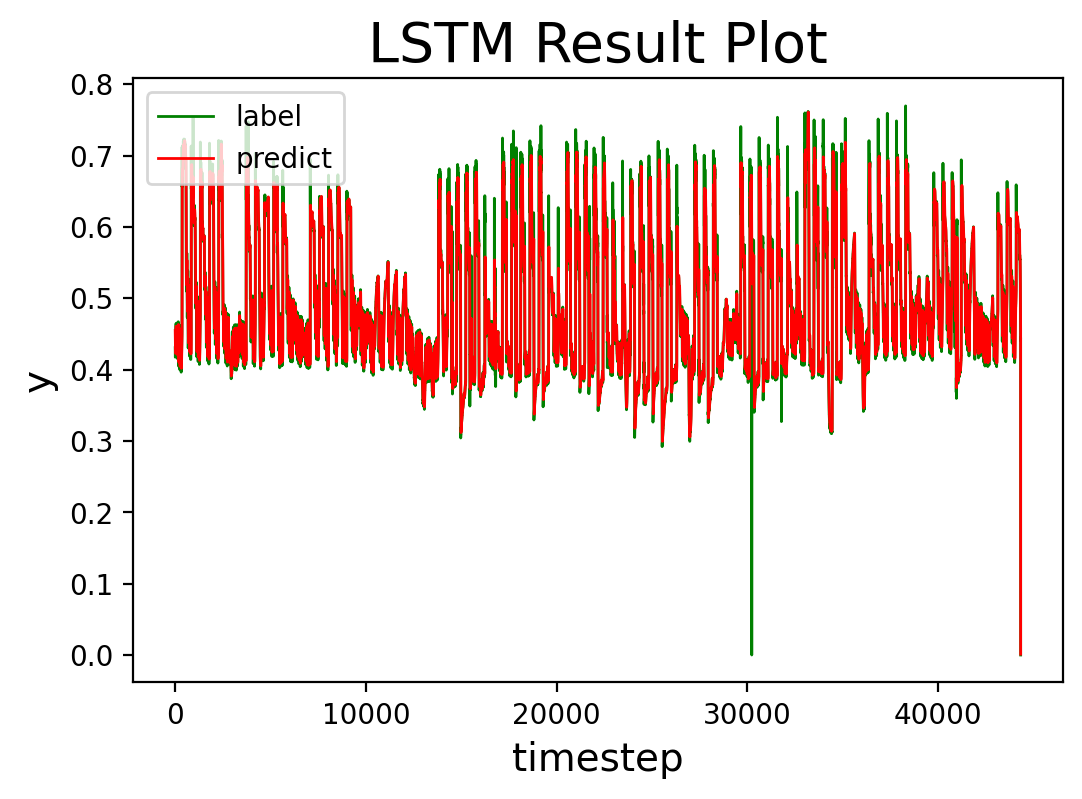

In [23]:
y_pre = model1.predict(X_test)
plot_result(y_true=y_test[:,config['seq_len']-1,:],y_pre=y_pre,model_name='LSTM')


In [49]:
plateau = ReduceLROnPlateau(monitor="val_loss", verbose=1, mode='min', factor=0.3, patience=5)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')
opt = adam_v2.Adam(lr=config['lr'])
model2.compile(
              loss='mse',
              optimizer=opt,
             metrics=['mse'])

# train the model
print("[INFO] training model...")
hist = model2.fit(
    X_train, y_train,
    validation_data=(X_train,y_train),
    callbacks=[early_stopping,plateau],shuffle=True,
    epochs=config['epoch'], batch_size=config['batch'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


[INFO] training model...
Epoch 1/50
2424/2424 [==============================] - 85s 33ms/step - loss: 0.0681 - mse: 0.0681 - val_loss: 0.0031 - val_mse: 0.0031 - lr: 1.0000e-04
Epoch 2/50
2424/2424 [==============================] - 71s 29ms/step - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0010 - val_mse: 0.0010 - lr: 1.0000e-04
Epoch 3/50
2424/2424 [==============================] - 69s 29ms/step - loss: 6.3686e-04 - mse: 6.3686e-04 - val_loss: 3.4009e-04 - val_mse: 3.4009e-04 - lr: 1.0000e-04
Epoch 4/50
2424/2424 [==============================] - 70s 29ms/step - loss: 2.5363e-04 - mse: 2.5363e-04 - val_loss: 1.8712e-04 - val_mse: 1.8712e-04 - lr: 1.0000e-04
Epoch 5/50
2424/2424 [==============================] - 69s 28ms/step - loss: 1.6524e-04 - mse: 1.6524e-04 - val_loss: 1.4955e-04 - val_mse: 1.4955e-04 - lr: 1.0000e-04
Epoch 6/50
2424/2424 [==============================] - 68s 28ms/step - loss: 1.4591e-04 - mse: 1.4591e-04 - val_loss: 1.4121e-04 - val_mse: 1.4121e-04 - lr: 1.00

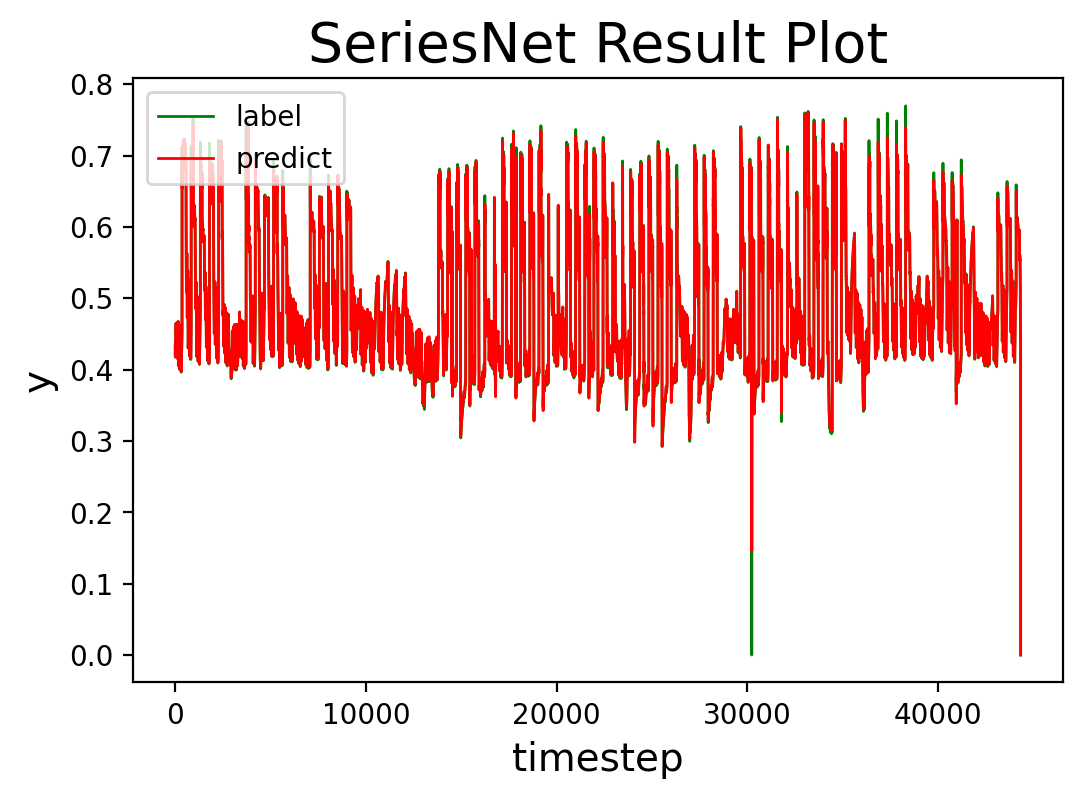

In [25]:
y_pre2 = model2.predict(X_test)
plot_result(y_true=y_test[:,config['seq_len']-1,:],y_pre=y_pre2[:,config['seq_len']-1,:],model_name='SeriesNet')


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


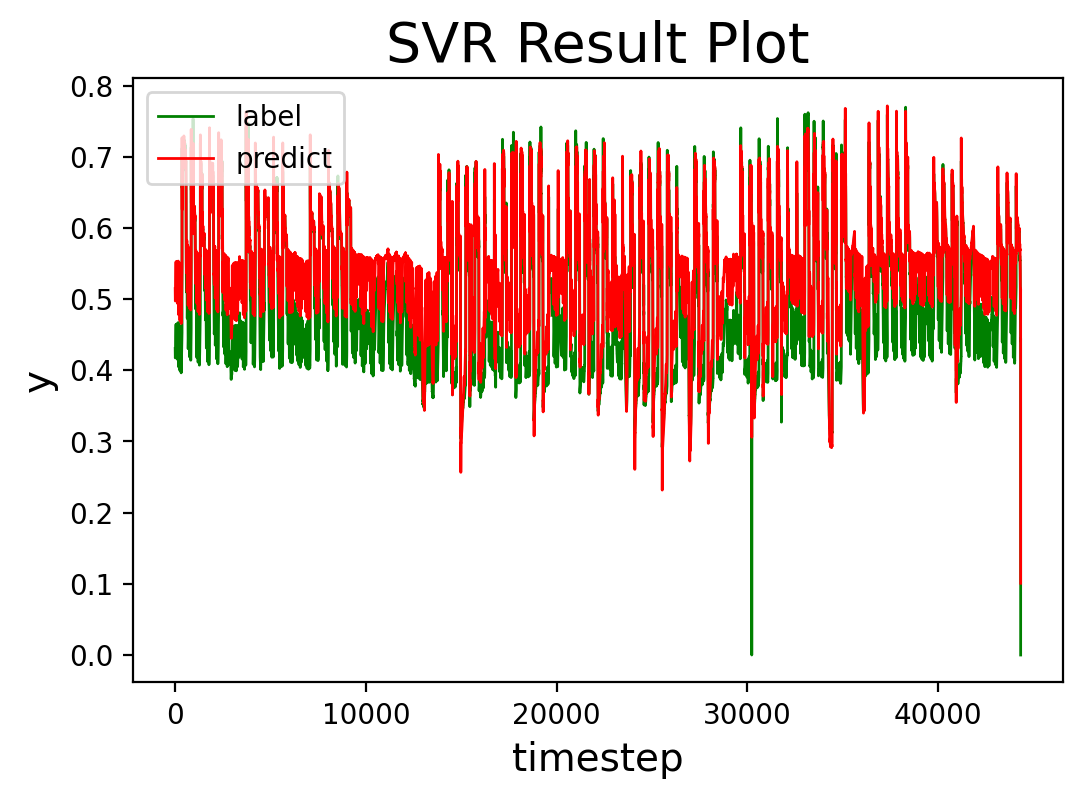

In [26]:
from sklearn.svm import SVR
svr_model = SVR(max_iter=1000)
svr_model.fit(X_train[:,:,0],y_train[:,config['seq_len']-1,:])
y_pre3 = svr_model.predict(X_test[:,:,0])
plot_result(y_true=y_test[:,config['seq_len']-1,:],y_pre=y_pre3,model_name='SVR')

In [27]:
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error
def evaluate(y_true,y_pre):
    
    res_dict = dict()
    r2 = r2_score(y_true,y_pre)
    mae = mean_absolute_error(y_true,y_pre)
    rmse = np.sqrt(mean_squared_error(y_true,y_pre))
    res_dict['r2'] = r2
    res_dict['mae'] = mae
    res_dict['rmse'] = rmse
    print(res_dict)
    return res_dict

In [28]:
res_dict = evaluate(y_test[:,config['seq_len']-1,:],y_pre)
res_dict2 = evaluate(y_test[:,config['seq_len']-1,:],y_pre2[:,config['seq_len']-1,:])
res_dict3 = evaluate(y_test[:,config['seq_len']-1,:],y_pre3)

{'r2': 0.9162371774545949, 'mae': 0.01397159950266204, 'rmse': 0.02753797916630341}
{'r2': 0.9856187520052717, 'mae': 0.003580920627684729, 'rmse': 0.011410500730668207}
{'r2': 0.6006478184617688, 'mae': 0.05067369050583346, 'rmse': 0.060129064351983265}


In [29]:
print('LSTM')
res_dict

LSTM


{'mae': 0.01397159950266204,
 'r2': 0.9162371774545949,
 'rmse': 0.02753797916630341}

In [30]:
print('SeriesNet')
res_dict2

SeriesNet


{'mae': 0.003580920627684729,
 'r2': 0.9856187520052717,
 'rmse': 0.011410500730668207}

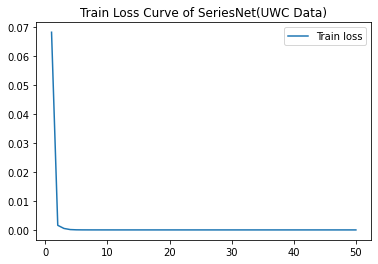

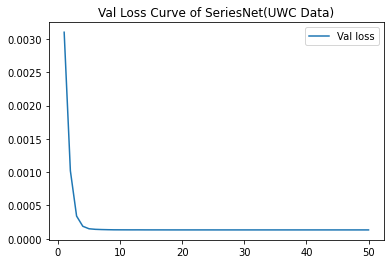

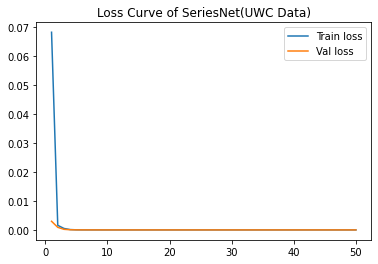

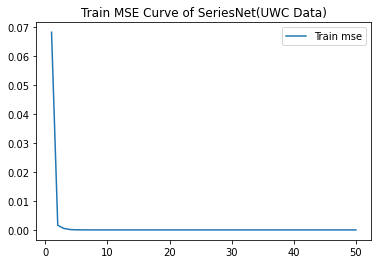

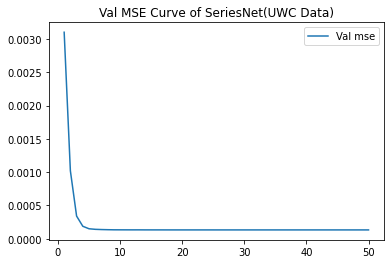

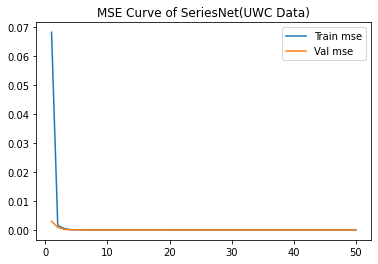

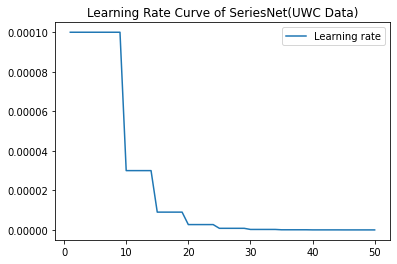

In [50]:
plot_all(hist, 'SeriesNet(UWC Data)')